# Analyzing simple experiments

This notebook shows you how to analyze simple experiments. We expect basic knowledge from CCS1 and CCS2 - have a look at the course materials if you are unsure.

## Setting up

In [1]:
# # only need to install this once, it's for some SPSSy stuff used in Psychology but not often used in Python
# !pip3 install psython
# !pip3 install pingouin
# !pip3 install prettytable
# !pip3 install factor_analyzer

In [2]:
import pandas as pd
import seaborn as sns
from statsmodels.formula.api import ols
import numpy as np
import psython as psy
import pingouin as pg
from scipy.stats import contingency 
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

## Loading the dataset

We first load the dataset and inspect it.
We also do necessary recoding.
Note that this is a "fake" dataset with simulated data; also note that your dataset may look slightly different. You should know everything about loading, recoding etc. from CCS1 and CCS2.

In [3]:
df = pd.read_csv("data.csv")
df

,group,gender,age,x1,x2,x3,x4,x5
0,1,female,24,2.0,2.0,3.0,3.0,3.0
1,1,female,18,3.0,2.0,4.0,4.0,3.0
2,1,male,24,3.0,3.0,2.0,3.0,3.0
3,1,female,25,2.0,2.0,2.0,2.0,3.0
4,1,female,19,2.0,2.0,2.0,2.0,2.0
...,...,...,...,...,...,...,...,...
392,4,female,18,3.0,2.0,4.0,3.0,4.0
393,4,male,23,3.0,3.0,4.0,4.0,3.0
394,4,male,20,5.0,4.0,3.0,4.0,4.0
395,4,female,18,4.0,3.0,3.0,4.0,3.0


### Let's look at what we have:

In [4]:
df['group'].value_counts(sort=False)

group
1     98
2     92
3    102
4    105
Name: count, dtype: int64

In [5]:
df['gender'].value_counts(sort=False)

gender
female    216
male      181
Name: count, dtype: int64

In [6]:
df['age'].describe()

count    397.000000
mean      22.528967
std        2.945171
min       18.000000
25%       20.000000
50%       23.000000
75%       25.000000
max       27.000000
Name: age, dtype: float64

<Axes: xlabel='gender', ylabel='count'>

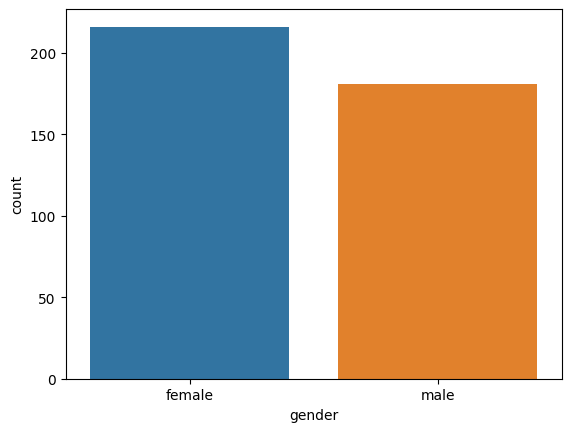

In [7]:
#or some plotting if we like
sns.countplot(x='gender', data=df)

<Axes: xlabel='age', ylabel='Count'>

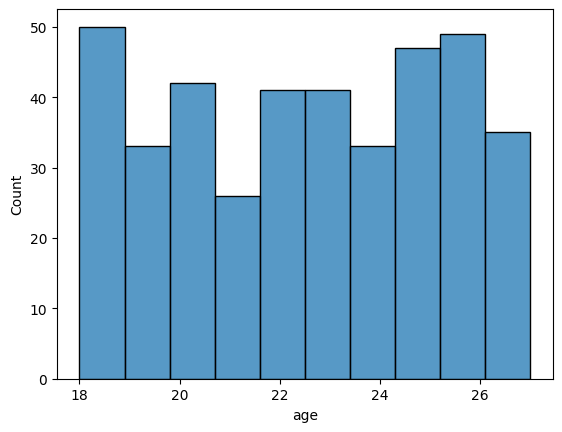

In [8]:
sns.histplot(x = 'age', data = df)

## Some recoding

When it comes recoding variables, two methods are most commonly used with experiment data:
- Reverse-coding (such that 5 becomes 1, 4 becomes 2, 3 remains 3, 2 becomes 4, and 1 becomes 5 for an item measured on a scale from 1 to 5).
- Dichotomizing (such that the values smaller or equal to a value becomes 0 and the values larger than a value becomes 1)

### Reverse code

In [9]:
# Let's consider the variable x1 below:
print(df['x1'].describe())

count    397.000000
mean       2.745592
std        0.777371
min        1.000000
25%        2.000000
50%        3.000000
75%        3.000000
max        5.000000
Name: x1, dtype: float64


In [10]:
# We can either do it with a fancy formula: 
# we multiply the variable with -1 and then add the highest value + 1 (thus, 5 in our case)
# check it with pen and paper, it works ;-)
df['x1_reverse_1'] = (df['x1'] * -1 + df['x1'].max() + 1)

# or we do it explicitly
df['x1_reverse_2'] = df['x1'].map({5:1, 4:2, 3:3, 2:4, 1:5})

### Dichotomize
This is handy when you want to split the sample into two groups based on one continuous variable. Then you usually do the "median split".

We use the variable `age` here as an example.

In [11]:
median = np.median(df['age'])
print(median)

df['age_dichotomous_1'] = (df['age']>=median).map(int)

# alternative:
df['age_dichotomous_2'] = np.where(df['age']>=median, 1, 0)

23.0


### Let's have a look at all our recoded colulms:

In [12]:
df[[col for col in df if col.startswith('x1') or col.startswith('age')]]

,age,x1,x1_reverse_1,x1_reverse_2,age_dichotomous_1,age_dichotomous_2
0,24,2.0,4.0,4,1,1
1,18,3.0,3.0,3,0,0
2,24,3.0,3.0,3,1,1
3,25,2.0,4.0,4,1,1
4,19,2.0,4.0,4,0,0
...,...,...,...,...,...,...
392,18,3.0,3.0,3,0,0
393,23,3.0,3.0,3,1,1
394,20,5.0,1.0,1,0,0
395,18,4.0,2.0,2,0,0


### Advanced stuff: Create new variable based on multiple columns
Imagine  you want to create a nominal variable, say, `mygroups` based on multiple other columns. You can do that using a function:

In [13]:
def makemygroups(row):
    # any combination of contitions can be entered here
    if row['age_dichotomous_1'] == 0 and row['group']<=2:
        return "group1"
    elif row['age_dichotomous_1'] == 1 and row['group']>2:
        return "group2"
    else:
        return "no group"
    
df['mygroups'] = df.apply(makemygroups,axis=1)
df['mygroups'].value_counts()

mygroups
no group    182
group2      115
group1      100
Name: count, dtype: int64

# All analyses from the slides

In this section of the notebook, we show *all* analyses from the lecture slides and how to do them in Python, in the order in which they are mentioned on the slides.

Check for more simple analyses https://pingouin-stats.org/ (including mediation analysis!)

For everything related to regression (and more advanced stuff), you may want to have a look at https://www.statsmodels.org/.


## Check validity (Factor analysis)
The code below is a condensed version from this: https://www.datasklr.com/principal-component-analysis-and-factor-analysis/factor-analysis <br>
You can find more comprehensive explanations from the link above.

Let's check whether the variables called `x1, x2, x3, x4, x5` can form one factor: 

In [14]:
items = df[['x1','x2','x3','x4','x5']]

#CHECK ADEQUACY
#Bartlett
#p-value should be 0 (statistically sig.)
chi_square_value,p_value=calculate_bartlett_sphericity(items)
print(chi_square_value, p_value)

#KMO
#Value should be 0.6<
kmo_all,kmo_model=calculate_kmo(items)
print(kmo_model)

634.0243760671544 8.97316663165576e-130
0.8181994102268773


In [15]:
# perform the factor analysis using the FactorAnalyzer class. You can specify the number of factors you want to extract using the n_factors parameter:
fa = FactorAnalyzer(n_factors = 1)

# fit the factor analysis model to your data
fa.fit(df[['x1','x2','x3','x4','x5']])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/factor_analyzer/factor_analyzer.py:662: UserWarning: No rotation will be performed when the number of factors equals 1.
  warnings.warn(


FactorAnalyzer(n_factors=1, rotation_kwargs={})

Obtain the factor loadings and other factor analysis results:

In [16]:
# Get the factor loadings
loadings = fa.loadings_

loadings

array([[-0.84072483],
       [-0.58270675],
       [-0.63994323],
       [-0.81542579],
       [-0.48841887]])

In [17]:
# Get the communalities
communalities = fa.get_communalities()

communalities

array([0.70681824, 0.33954716, 0.40952733, 0.66491921, 0.23855299])

In [18]:
# Get the eigenvalues
#         Returns
#         -------
#         original_eigen_values : :obj:`numpy.ndarray`
#             The original eigenvalues
#         common_factor_eigen_values : :obj:`numpy.ndarray`
#             The common factor eigenvalues
eigenvalues = fa.get_eigenvalues()

np.round(eigenvalues, decimals = 2)

array([[ 2.83,  0.76,  0.65,  0.42,  0.34],
       [ 2.36,  0.08,  0.02, -0.02, -0.08]])

In [19]:
# Get the variance explained by each factor;  
#         Returns
#         -------
#         variance : :obj:`numpy.ndarray`
#             The factor variances.
#         proportional_variance : :obj:`numpy.ndarray`
#             The proportional factor variances.
#         cumulative_variances : :obj:`numpy.ndarray`
#             The cumulative factor variances.
variance_explained = fa.get_factor_variance()

variance_explained

(array([2.35936493]), array([0.47187299]), array([0.47187299]))

## Check reliability (Cronbach's Alpha)

Let's check whether the variables called `x1, x2, x3, x4, x5` reliably measure the same construct: 

In [20]:
# Calculate the initial Cronbach's alpha
pg.cronbach_alpha(items)

(0.803510414925882, array([0.771, 0.832]))

In [21]:
# calculate the alpha value without each item
alpha_deleted_items = []
for item in items.columns:
    reduced_data = items.drop(item, axis=1)
    alpha = pg.cronbach_alpha(reduced_data)
    alpha_deleted_items.append((item, alpha))

for item, alpha in alpha_deleted_items:
    print("Item removed:", item)
    print("Cronbach's alpha:", alpha)
    print()

Item removed: x1
Cronbach's alpha: (0.7197961617260301, array([0.672, 0.762]))

Item removed: x2
Cronbach's alpha: (0.7877923122294348, array([0.752, 0.82 ]))

Item removed: x3
Cronbach's alpha: (0.7722516414998, array([0.733, 0.807]))

Item removed: x4
Cronbach's alpha: (0.7280150506542677, array([0.682, 0.769]))

Item removed: x5
Cronbach's alpha: (0.8099066427480023, array([0.777, 0.839]))



### If we are satisfied, maybe make a new variable by calculating the mean

In [22]:
df['dv'] = df[['x1','x2','x3','x4','x5']].mean(axis=1)   # of course, only select those you're interested in

## Some simple group comparison

In [23]:
# descriptives of dv per group
df.groupby('group')['dv'].describe()

,count,mean,std,min,25%,50%,75%,max
group,,,,,,,,
1,98.0,2.667347,0.556827,1.2,2.4,2.8,3.0,4.2
2,92.0,2.456522,0.522316,1.4,2.0,2.4,2.8,3.8
3,102.0,2.762745,0.432108,1.6,2.6,2.8,3.0,3.8
4,105.0,2.963810,0.579642,1.8,2.4,3.0,3.4,4.2


<Axes: xlabel='group', ylabel='dv'>

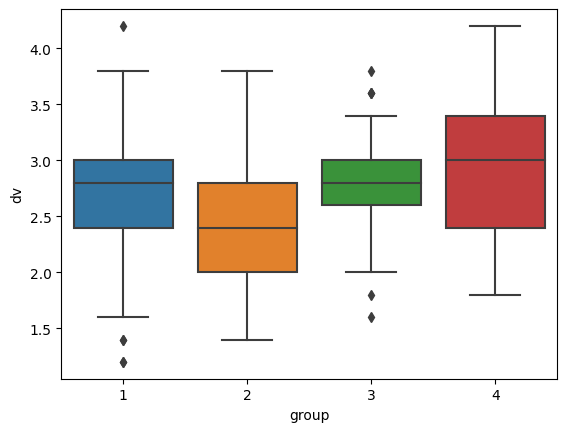

In [24]:
# some visualization
sns.boxplot(y='dv', x='group', data=df)

### $\chi^2$ -test (chi2-test)

In [25]:
#let's look at the crosstab
mycrosstab = pd.crosstab(df['gender'], df['age_dichotomous_1'])
mycrosstab

age_dichotomous_1,0,1
gender,,
female,109,107
male,83,98


In [26]:
# and then get the chi2 test for that table
c, p, dof, expected = contingency.chi2_contingency(mycrosstab)
print(f"𝜒²({dof:.0f}) = {c:.3f}, p = {p:.3f} ")

# maybe Cramer's V as well?
print(f"V = {contingency.association(mycrosstab,method='cramer'):.3f}")

𝜒²(1) = 0.663, p = 0.416 
V = 0.046


### Levene's test

In [27]:
from scipy.stats import levene

# Create three arrays for each sample:
groupf = df.query('gender == "female"')['dv']
groupm = df.query('gender == "male"')['dv']

# Levene's Test in Python with Scipy:
stat, p = levene(groupf, groupm)

print(stat, p)

1.720882676015554 0.1903413618401527


### T-test

You only need to specify the variable you group by (gender) and the variable you want to test (dv) in the first line of the code and we'll print a nicely formated sentence! (plus the table)

In [28]:
(label1, values1), (label2, values2) = df.groupby('gender')['dv']

testresult = pg.ttest(values1, values2)

print(f"We compare {label1} (M={np.mean(values1):.2f}, SD={np.std(values1):.3f}) "
     f"with {label2} (M={np.mean(values2):.2f}, SD={np.std(values2):.3f}), "
     f"t({testresult.iloc[0,1]})={testresult.iloc[0,0]:.3f}, "
     f"p={testresult.iloc[0,3]:.4f}.")

testresult

We compare female (M=2.70, SD=0.578) with male (M=2.75, SD=0.523), t(392.61375191019977)=-0.884, p=0.3772.


,T,dof,alternative,p-val,CI95%,cohen-d,BF10,power
T-test,-0.884132,392.613752,two-sided,0.377166,"[-0.16, 0.06]",0.088317,0.163,0.14111


### ANOVA


In [29]:
aov = pg.anova(data=df, dv='dv', between='group', detailed=True)
aov

,Source,SS,DF,MS,F,p-unc,np2
0,group,13.085505,3,4.361835,15.769657,1.057304e-09,0.107445
1,Within,108.702505,393,0.276597,NaN,NaN,NaN


In [30]:
# post-hoc test
df.pairwise_tukey(dv='dv', between='group').round(3)

,A,B,mean(A),mean(B),diff,se,T,p-tukey,hedges
0,1,2,2.667,2.457,0.211,0.076,2.761,0.031,0.389
1,1,3,2.667,2.763,-0.095,0.074,-1.282,0.575,-0.191
2,1,4,2.667,2.964,-0.296,0.074,-4.013,0.000,-0.519
3,2,3,2.457,2.763,-0.306,0.076,-4.050,0.000,-0.639
4,2,4,2.457,2.964,-0.507,0.075,-6.754,0.000,-0.913
5,3,4,2.763,2.964,-0.201,0.073,-2.750,0.032,-0.391


### ANOVA with interaction effect

Let's say we don't have a `1x4` but a `2x2` design:

In [31]:
# imagine that group 1 is personalized and interactive, 2 is only personalized, 3 is not interactive but personalized, and 4 is neither
df['personalized']=False
df['interactive']=False
df.loc[df['group']==1,'personalized']=True
df.loc[df['group']==2,'personalized']=True
df.loc[df['group']==1,'interactive']=True
df.loc[df['group']==3,'interactive']=True

In [32]:
df.anova(dv="dv", between=["interactive", "personalized"],effsize="n2").round(3)

,Source,SS,DF,MS,F,p-unc,n2
0,interactive,0.002,1.0,0.002,0.006,0.939,0.000
1,personalized,8.875,1.0,8.875,32.085,0.000,0.073
2,interactive * personalized,4.199,1.0,4.199,15.182,0.000,0.034
3,Residual,108.703,393.0,0.277,NaN,NaN,NaN


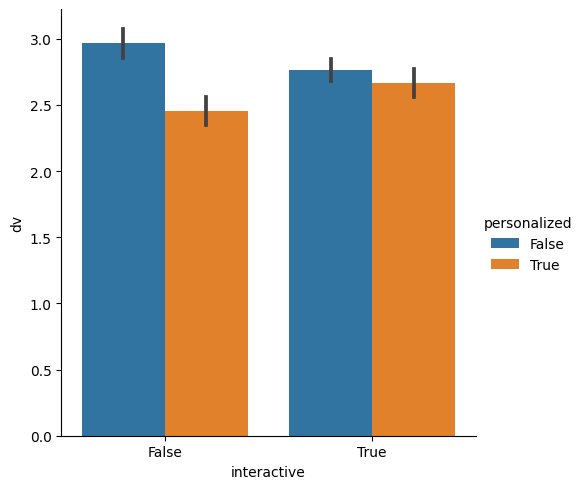

In [33]:
# interaction plot:
sns.catplot(x='interactive', y='dv', hue='personalized', kind='bar', data=df)

### ANCOVA

In [34]:
df['gender_int'] = df['gender'].map({"male":1,"female":0})

In [35]:
pg.ancova(data=df, dv='dv', covar=['age', 'gender_int'], between='group',effsize="n2")

,Source,SS,DF,F,p-unc,n2
0,group,12.891388,3,15.464759,1.586913e-09,0.106021
1,age,0.028897,1,0.103997,7.472571e-01,0.000238
2,gender_int,0.027351,1,0.098432,7.538865e-01,0.000225
3,Residual,108.645574,391,NaN,NaN,NaN


### Mediation Analysis
Let's assume that we want to recode `x1, x2, ... x5` from the dataframe above into `some_mediator` (see Cronbach's alpha above) and test the model `age --> some_mediator --> dv`:

In [36]:
df['some_mediator'] = df[['x1','x2','x3','x4','x5']].mean(axis=1)

In [37]:
pg.mediation_analysis(data=df, x='age', m='some_mediator', y='dv', seed=42, n_boot=1000)

,path,coef,se,pval,CI[2.5%],CI[97.5%],sig
0,some_mediator ~ X,0.002185,9.473629e-03,0.81775,-1.644048e-02,2.080960e-02,No
1,Y ~ some_mediator,1.000000,1.829019e-17,0.00000,1.000000e+00,1.000000e+00,Yes
2,Total,0.002185,9.473629e-03,0.81775,-1.644048e-02,2.080960e-02,No
3,Direct,0.000000,1.053626e-17,1.00000,-2.071432e-17,2.071432e-17,No
4,Indirect,0.002185,9.091138e-03,0.77200,-1.577289e-02,1.928502e-02,No


### Regression analysis

In [38]:
# This is how one could compare the groups using a regresion analysis.

ols("dv~C(group) + age + C(gender)", data=df).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dv   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     9.460
Date:                Tue, 30 May 2023   Prob (F-statistic):           1.58e-08
Time:                        17:09:18   Log-Likelihood:                -306.09
No. Observations:                 397   AIC:                             624.2
Df Residuals:                     391   BIC:                             648.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.5962      0.208     12.469      0.000       2.187       3.006
C(group)[T.2]        -0.2127      0.077     -2.775      0.006      -0.363      -0.062
C(group)[T.3]         0.0922      0.075      1.231      0.219      -0.055       0.239
C(group)[T.4]         0.2934      0.074      3.940      0.000       0.147       0.440
C(gender)[T.male]     0.0168      0.053      0.314      0.754      -0.088       0.122
age                   0.0029      0.009      0.322      0.747      -0.015       0.021
==============================================================================
Omnibus:                        0.507   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.776   Jarque-Bera (JB):                0.621
Skew:                          -0.017   Prob(JB):                        0.733
Kurtosis:                       2.809   Cond. No.                         180.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""